# SciPy在金融数据分析与量化中的应用

本notebook将详细介绍SciPy在金融数据分析和量化投资中的重要应用，包括：

## 目录
1. **统计分析** - 描述性统计、假设检验、分布拟合
2. **优化算法** - 投资组合优化、参数估计
3. **插值与拟合** - 收益率曲线构建、缺失数据处理
4. **信号处理** - 技术指标计算、数据平滑
5. **数值积分** - 期权定价、风险度量
6. **线性代数** - 协方差矩阵、主成分分析

---

## 环境准备


In [4]:
# 导入必要的库
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats, optimize, interpolate, signal, integrate, linalg
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体和图表样式
matplotlib.rcParams['font.sans-serif'] = ['SimHei']   # 黑体
matplotlib.rcParams['axes.unicode_minus'] = False     # 正常显示负号
sns.set_style("whitegrid")
plt.style.use('seaborn-v0_8')

print("SciPy版本:", scipy.__version__)
print("环境配置完成！")


SciPy版本: 1.13.0
环境配置完成！


# 1. 统计分析 (scipy.stats)

## 1.1 金融数据的描述性统计

在金融数据分析中，我们经常需要分析收益率的分布特征，包括：
- **偏度 (Skewness)**: 衡量分布的不对称性
- **峰度 (Kurtosis)**: 衡量分布的尖峭程度
- **正态性检验**: 判断数据是否符合正态分布
- **分布拟合**: 寻找最适合数据的概率分布


In [5]:
# 生成模拟股票收益率数据
np.random.seed(42)
n_days = 1000

# 模拟三只股票的日收益率
stock_a = np.random.normal(0.001, 0.02, n_days)  # 正态分布
stock_b = np.random.exponential(0.01, n_days) - 0.005  # 右偏分布
stock_c = np.random.laplace(0.002, 0.015, n_days)  # 尖峭分布

returns_data = pd.DataFrame({
    '股票A': stock_a,
    '股票B': stock_b, 
    '股票C': stock_c
})

print("模拟数据基本信息:")
print(returns_data.describe())


模拟数据基本信息:
               股票A          股票B          股票C
count  1000.000000  1000.000000  1000.000000
mean      0.001387     0.005080     0.001118
std       0.019584     0.010030     0.021880
min      -0.063825    -0.004968    -0.158025
25%      -0.011952    -0.002160    -0.008011
50%       0.001506     0.002259     0.001749
75%       0.013959     0.008717     0.011730
max       0.078055     0.069417     0.083535


In [6]:
# 计算高阶矩统计量
def calculate_moments(data):
    """计算金融时间序列的关键统计量"""
    results = {}
    
    for col in data.columns:
        series = data[col]
        results[col] = {
            '均值': np.mean(series),
            '标准差': np.std(series),
            '偏度': stats.skew(series),
            '峰度': stats.kurtosis(series),
            '最大值': np.max(series),
            '最小值': np.min(series),
            'VaR_5%': np.percentile(series, 5),  # 5%风险价值
            'CVaR_5%': np.mean(series[series <= np.percentile(series, 5)])  # 条件风险价值
        }
    
    return pd.DataFrame(results).T

moments_df = calculate_moments(returns_data)
print("金融统计量分析:")
print(moments_df.round(6))


金融统计量分析:
           均值       标准差        偏度        峰度       最大值       最小值    VaR_5%  \
股票A  0.001387  0.019575  0.116801  0.066206  0.078055 -0.063825 -0.029519   
股票B  0.005080  0.010025  1.980812  5.379440  0.069417 -0.004968 -0.004412   
股票C  0.001118  0.021869 -0.781966  4.915058  0.083535 -0.158025 -0.033114   

      CVaR_5%  
股票A -0.037540  
股票B -0.004711  
股票C -0.054206  


In [7]:
# 正态性检验
def normality_tests(data):
    """对收益率数据进行正态性检验"""
    results = {}
    
    for col in data.columns:
        series = data[col]
        
        # Shapiro-Wilk检验 (适用于小样本)
        shapiro_stat, shapiro_p = stats.shapiro(series[:100])  # 取前100个样本
        
        # Kolmogorov-Smirnov检验
        ks_stat, ks_p = stats.kstest(series, 'norm', args=(np.mean(series), np.std(series)))
        
        # Jarque-Bera检验 (基于偏度和峰度)
        jb_stat, jb_p = stats.jarque_bera(series)
        
        results[col] = {
            'Shapiro_统计量': shapiro_stat,
            'Shapiro_p值': shapiro_p,
            'KS_统计量': ks_stat,
            'KS_p值': ks_p,
            'JB_统计量': jb_stat,
            'JB_p值': jb_p,
            '是否正态分布': 'Yes' if min(shapiro_p, ks_p, jb_p) > 0.05 else 'No'
        }
    
    return pd.DataFrame(results).T

normality_results = normality_tests(returns_data)
print("正态性检验结果:")
print(normality_results.round(6))


正态性检验结果:
    Shapiro_统计量 Shapiro_p值    KS_统计量     KS_p值       JB_统计量     JB_p值 是否正态分布
股票A    0.989883   0.655168   0.02148  0.736957     2.456373  0.292823    Yes
股票B    0.823758        0.0  0.158107       0.0  1859.701825       0.0     No
股票C     0.93789   0.000144  0.091211       0.0  1108.486726       0.0     No


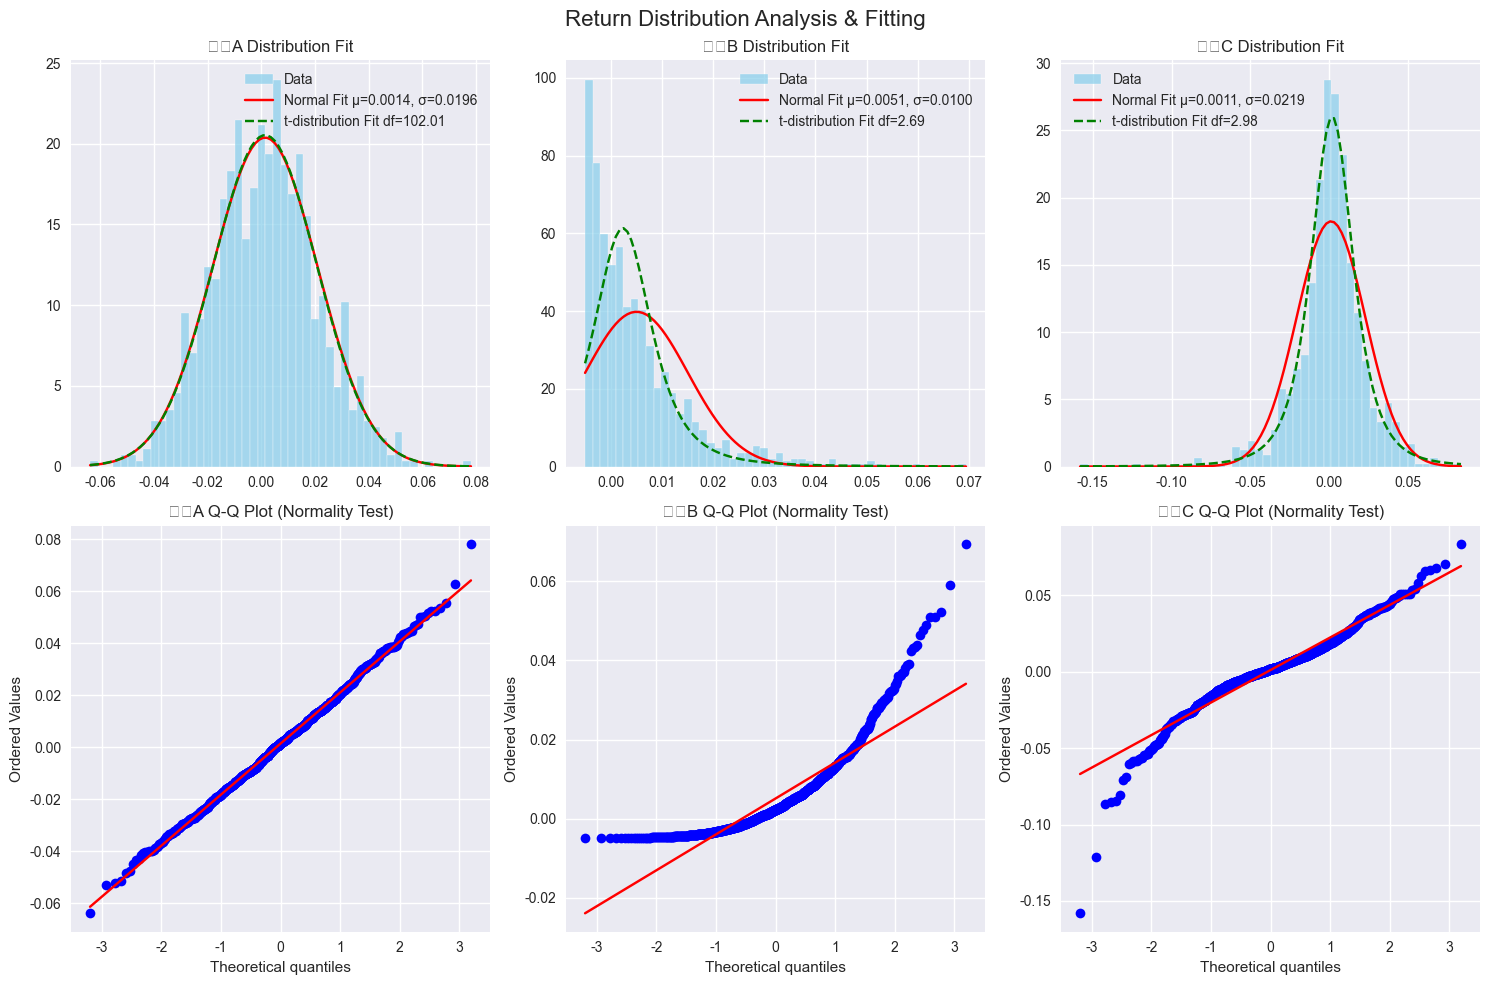

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Distribution fitting & visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Return Distribution Analysis & Fitting', fontsize=16)

for i, col in enumerate(returns_data.columns):
    data = returns_data[col]
    
    # Histogram and density
    axes[0, i].hist(data, bins=50, density=True, alpha=0.7, color='skyblue', label='Data')
    
    # Normal distribution fitting
    mu, sigma = stats.norm.fit(data)
    x = np.linspace(data.min(), data.max(), 100)
    axes[0, i].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', label=f'Normal Fit μ={mu:.4f}, σ={sigma:.4f}')
    
    # t-distribution fitting
    df, loc, scale = stats.t.fit(data)
    axes[0, i].plot(x, stats.t.pdf(x, df, loc, scale), 'g--', label=f't-distribution Fit df={df:.2f}')
    
    axes[0, i].set_title(f'{col} Distribution Fit')
    axes[0, i].legend()
    axes[0, i].grid(True)
    
    # Q-Q plot
    stats.probplot(data, dist="norm", plot=axes[1, i])
    axes[1, i].set_title(f'{col} Q-Q Plot (Normality Test)')
    axes[1, i].grid(True)

plt.tight_layout()
plt.show()


# 3. 插值与拟合 (scipy.interpolate)

## 3.1 收益率曲线构建

在固定收益分析中，我们经常需要从离散的市场数据构建连续的收益率曲线：
- **线性插值**: 简单快速，适用于短期数据
- **样条插值**: 平滑曲线，适用于长期利率建模
- **多项式拟合**: 捕捉趋势，用于期限结构分析
- **缺失数据处理**: 填补价格序列中的空白


Raw market data:
   Maturity (Years)  Yield (%)
0              0.25        1.5
1              0.50        1.8
2              1.00        2.1
3              2.00        2.4
4              3.00        2.6
5              5.00        2.9
6              7.00        3.1
7             10.00        3.2
8             20.00        3.4
9             30.00        3.3


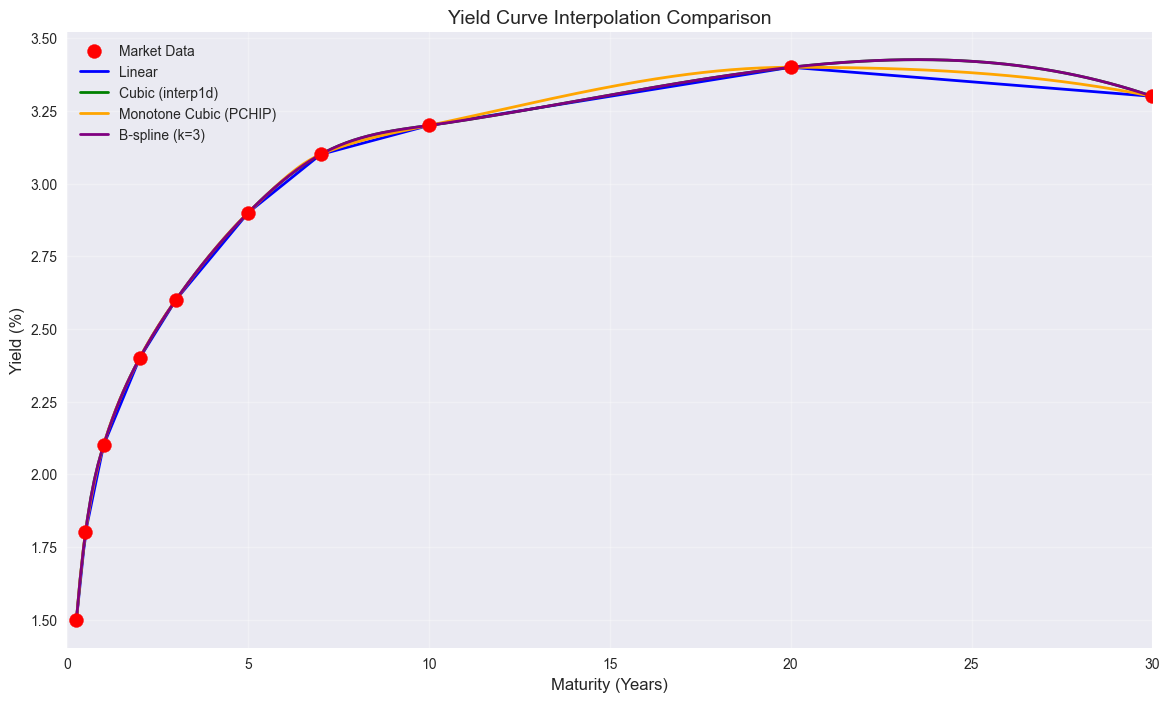


Fitting MSE at original points:
Linear: MSE = 0.000000
Cubic (interp1d): MSE = 0.000000
Monotone Cubic (PCHIP): MSE = 0.000000
B-spline (k=3): MSE = 0.000000


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate

# Simulated yield curve data
maturities = np.array([0.25, 0.5, 1, 2, 3, 5, 7, 10, 20, 30])
yields = np.array([1.5, 1.8, 2.1, 2.4, 2.6, 2.9, 3.1, 3.2, 3.4, 3.3])

print("Raw market data:")
yield_data = pd.DataFrame({'Maturity (Years)': maturities, 'Yield (%)': yields})
print(yield_data)

fine_maturities = np.linspace(0.25, 30, 300)

# Build interpolators (use callable objects directly; no BSpline.from_power_basis)
interpolators = {
    'Linear': interpolate.interp1d(maturities, yields, kind='linear', bounds_error=False, fill_value="extrapolate"),
    'Cubic (interp1d)': interpolate.interp1d(maturities, yields, kind='cubic', bounds_error=False, fill_value="extrapolate"),
    'Monotone Cubic (PCHIP)': interpolate.PchipInterpolator(maturities, yields, extrapolate=True),
    'B-spline (k=3)': interpolate.make_interp_spline(maturities, yields, k=3),
}

# Compute interpolated curves
interpolated_yields = {name: func(fine_maturities) for name, func in interpolators.items()}

# Plot curves
plt.figure(figsize=(14, 8))
plt.scatter(maturities, yields, color='red', s=100, zorder=5, label='Market Data')

palette = {
    'Linear': 'blue',
    'Cubic (interp1d)': 'green',
    'Monotone Cubic (PCHIP)': 'orange',
    'B-spline (k=3)': 'purple'
}
for name, curve in interpolated_yields.items():
    plt.plot(fine_maturities, curve, color=palette[name], linewidth=2, label=name)

plt.xlabel('Maturity (Years)', fontsize=12)
plt.ylabel('Yield (%)', fontsize=12)
plt.title('Yield Curve Interpolation Comparison', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 30)
plt.show()

# Fit accuracy at original knots
print("\nFitting MSE at original points:")
for name, func in interpolators.items():
    fitted = func(maturities)
    mse = np.mean((fitted - yields) ** 2)
    print(f"{name}: MSE = {mse:.6f}")


## 3.2 缺失数据处理

在实际金融数据中，经常遇到缺失值问题，插值技术可以帮助我们合理填补这些空白。


Total data points: 100
Missing data points: 15
Missing ratio: 15.0%


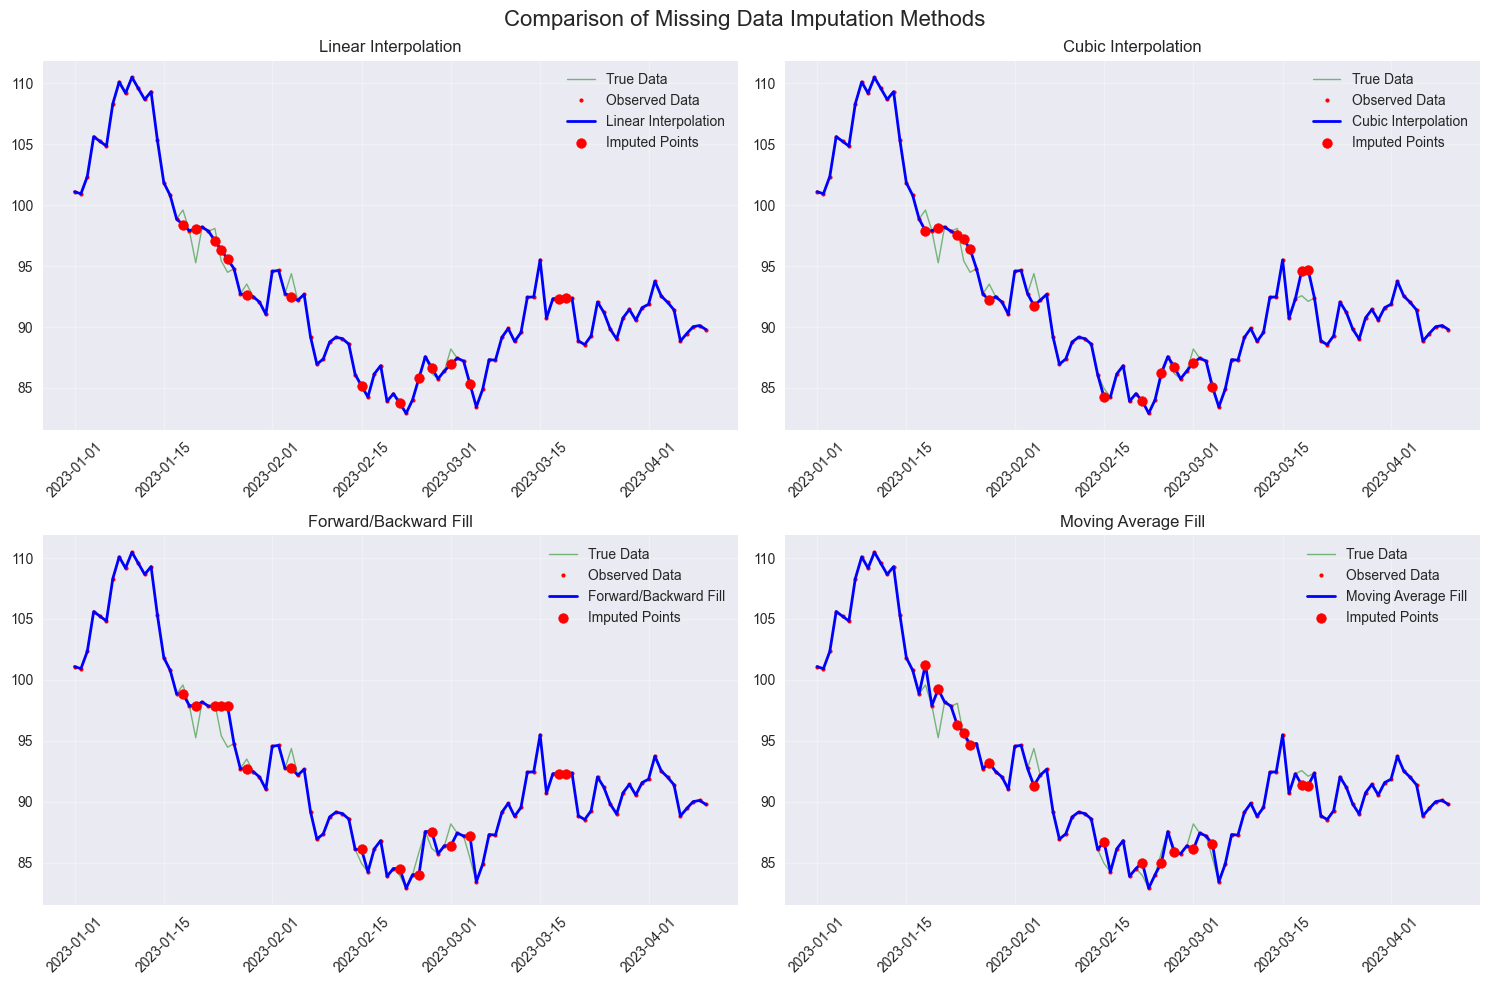


Accuracy Evaluation of Imputation Methods:
Method			MAE		MSE		MAPE(%)
------------------------------------------------------------
Linear Interpolation	0.8383		1.2450		0.89
Cubic Interpolation 	1.3664		2.6733		1.47
Forward/Backward Fill	1.3867		2.7711		1.52
Moving Average Fill 	1.3599		2.9312		1.48


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate

# Create price series with missing values
np.random.seed(42)
dates = pd.date_range('2023-01-01', periods=100, freq='D')
prices = 100 * np.exp(np.cumsum(np.random.normal(0.001, 0.02, 100)))

# Randomly create missing values
missing_indices = np.random.choice(range(10, 90), size=15, replace=False)
prices_with_missing = prices.copy()
prices_with_missing[missing_indices] = np.nan

# Create DataFrame
price_df = pd.DataFrame({
    'date': dates,
    'original_price': prices,
    'price_with_missing': prices_with_missing
})

print(f"Total data points: {len(prices)}")
print(f"Missing data points: {len(missing_indices)}")
print(f"Missing ratio: {len(missing_indices)/len(prices)*100:.1f}%")

# Different interpolation/imputation methods
def fill_missing_data(series):
    """Fill missing values using different methods"""
    results = {}
    
    # Get non-missing positions
    valid_idx = ~np.isnan(series)
    valid_positions = np.where(valid_idx)[0]
    valid_values = series[valid_idx]
    
    # Missing positions
    missing_positions = np.where(~valid_idx)[0]
    
    if len(missing_positions) == 0:
        return {'Original Data': series}
    
    # 1. Linear interpolation
    linear_interp = interpolate.interp1d(valid_positions, valid_values, 
                                         kind='linear', fill_value='extrapolate')
    linear_filled = series.copy()
    linear_filled[missing_positions] = linear_interp(missing_positions)
    results['Linear Interpolation'] = linear_filled
    
    # 2. Cubic interpolation
    if len(valid_values) >= 4:  # cubic requires at least 4 points
        cubic_interp = interpolate.interp1d(valid_positions, valid_values, 
                                            kind='cubic', fill_value='extrapolate')
        cubic_filled = series.copy()
        cubic_filled[missing_positions] = cubic_interp(missing_positions)
        results['Cubic Interpolation'] = cubic_filled
    
    # 3. Forward fill + backward fill
    forward_filled = pd.Series(series).fillna(method='ffill').fillna(method='bfill').values
    results['Forward/Backward Fill'] = forward_filled
    
    # 4. Moving average fill
    ma_filled = series.copy()
    for idx in missing_positions:
        # use 5 neighbors before and after
        start_idx = max(0, idx-5)
        end_idx = min(len(series), idx+6)
        window_data = series[start_idx:end_idx]
        valid_window = window_data[~np.isnan(window_data)]
        if len(valid_window) > 0:
            ma_filled[idx] = np.mean(valid_window)
    results['Moving Average Fill'] = ma_filled
    
    return results

# Apply different methods
filled_results = fill_missing_data(prices_with_missing)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Comparison of Missing Data Imputation Methods', fontsize=16)

methods = list(filled_results.keys())
for i, method in enumerate(methods):
    row, col = i // 2, i % 2
    ax = axes[row, col]
    
    # Original data
    ax.plot(dates, prices, 'g-', alpha=0.5, linewidth=1, label='True Data')
    
    # Observed with missing
    ax.plot(dates, prices_with_missing, 'ro', markersize=3, label='Observed Data')
    
    # Filled data
    ax.plot(dates, filled_results[method], 'b-', linewidth=2, label=f'{method}')
    
    # Mark missing points
    missing_dates = dates[missing_indices]
    missing_filled = filled_results[method][missing_indices]
    ax.scatter(missing_dates, missing_filled, color='red', s=50, zorder=5, label='Imputed Points')
    
    ax.set_title(f'{method}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Accuracy evaluation (compare with true values at missing points)
print("\nAccuracy Evaluation of Imputation Methods:")
print("Method\t\t\tMAE\t\tMSE\t\tMAPE(%)")
print("-" * 60)

for method, filled_data in filled_results.items():
    # only compare at missing points
    true_missing = prices[missing_indices]
    filled_missing = filled_data[missing_indices]
    
    mae = np.mean(np.abs(true_missing - filled_missing))
    mse = np.mean((true_missing - filled_missing)**2)
    mape = np.mean(np.abs((true_missing - filled_missing) / true_missing)) * 100
    
    print(f"{method:<20}\t{mae:.4f}\t\t{mse:.4f}\t\t{mape:.2f}")


# 4. 信号处理 (scipy.signal)

## 4.1 技术指标与滤波

信号处理技术在量化交易中有广泛应用：
- **移动平均滤波**: 去除价格噪声，识别趋势
- **带通滤波**: 提取特定频率的市场周期
- **峰值检测**: 识别价格的局部极值点
- **频谱分析**: 分析价格序列的周期性成分


Generated 504 days of simulated stock price data
Initial price: 100
Final price: 26628626335737.91
Total return: 26628626335637.91%


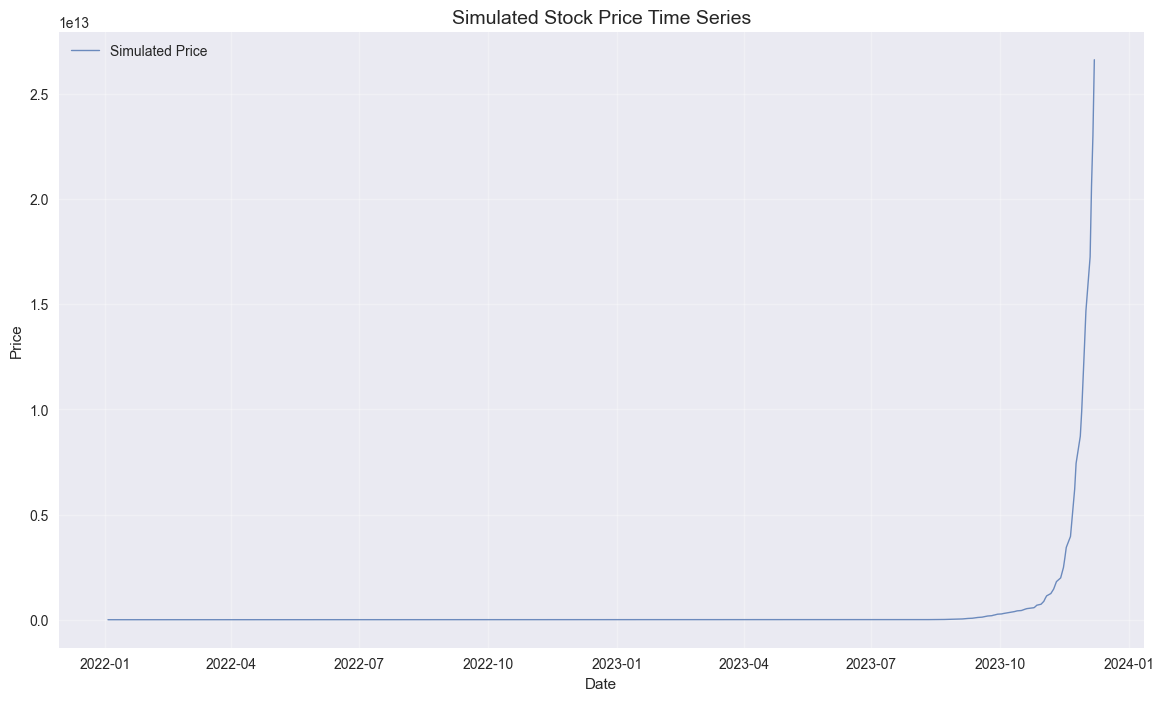

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate simulated stock price data
np.random.seed(42)
n_days = 252 * 2  # 2 years of trading days

# Simulate stock price path (trend + seasonality + noise)
t = np.arange(n_days)
trend = 0.0002 * t                            # long-term upward trend
seasonal = 0.05 * np.sin(2 * np.pi * t / 60)  # 60-day cycle
noise = np.random.normal(0, 0.02, n_days)     # random noise

# Generate log returns
log_returns = trend + seasonal + noise

# Convert to price series
initial_price = 100
prices = initial_price * np.exp(np.cumsum(log_returns))

# Create date index
dates = pd.date_range('2022-01-01', periods=n_days, freq='B')  # business days
price_series = pd.Series(prices, index=dates)

print(f"Generated {n_days} days of simulated stock price data")
print(f"Initial price: {initial_price}")
print(f"Final price: {prices[-1]:.2f}")
print(f"Total return: {(prices[-1]/initial_price - 1)*100:.2f}%")

# Visualization of simulated stock prices
plt.figure(figsize=(14, 8))
plt.plot(dates, prices, linewidth=1, alpha=0.8, label='Simulated Price')
plt.title('Simulated Stock Price Time Series', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


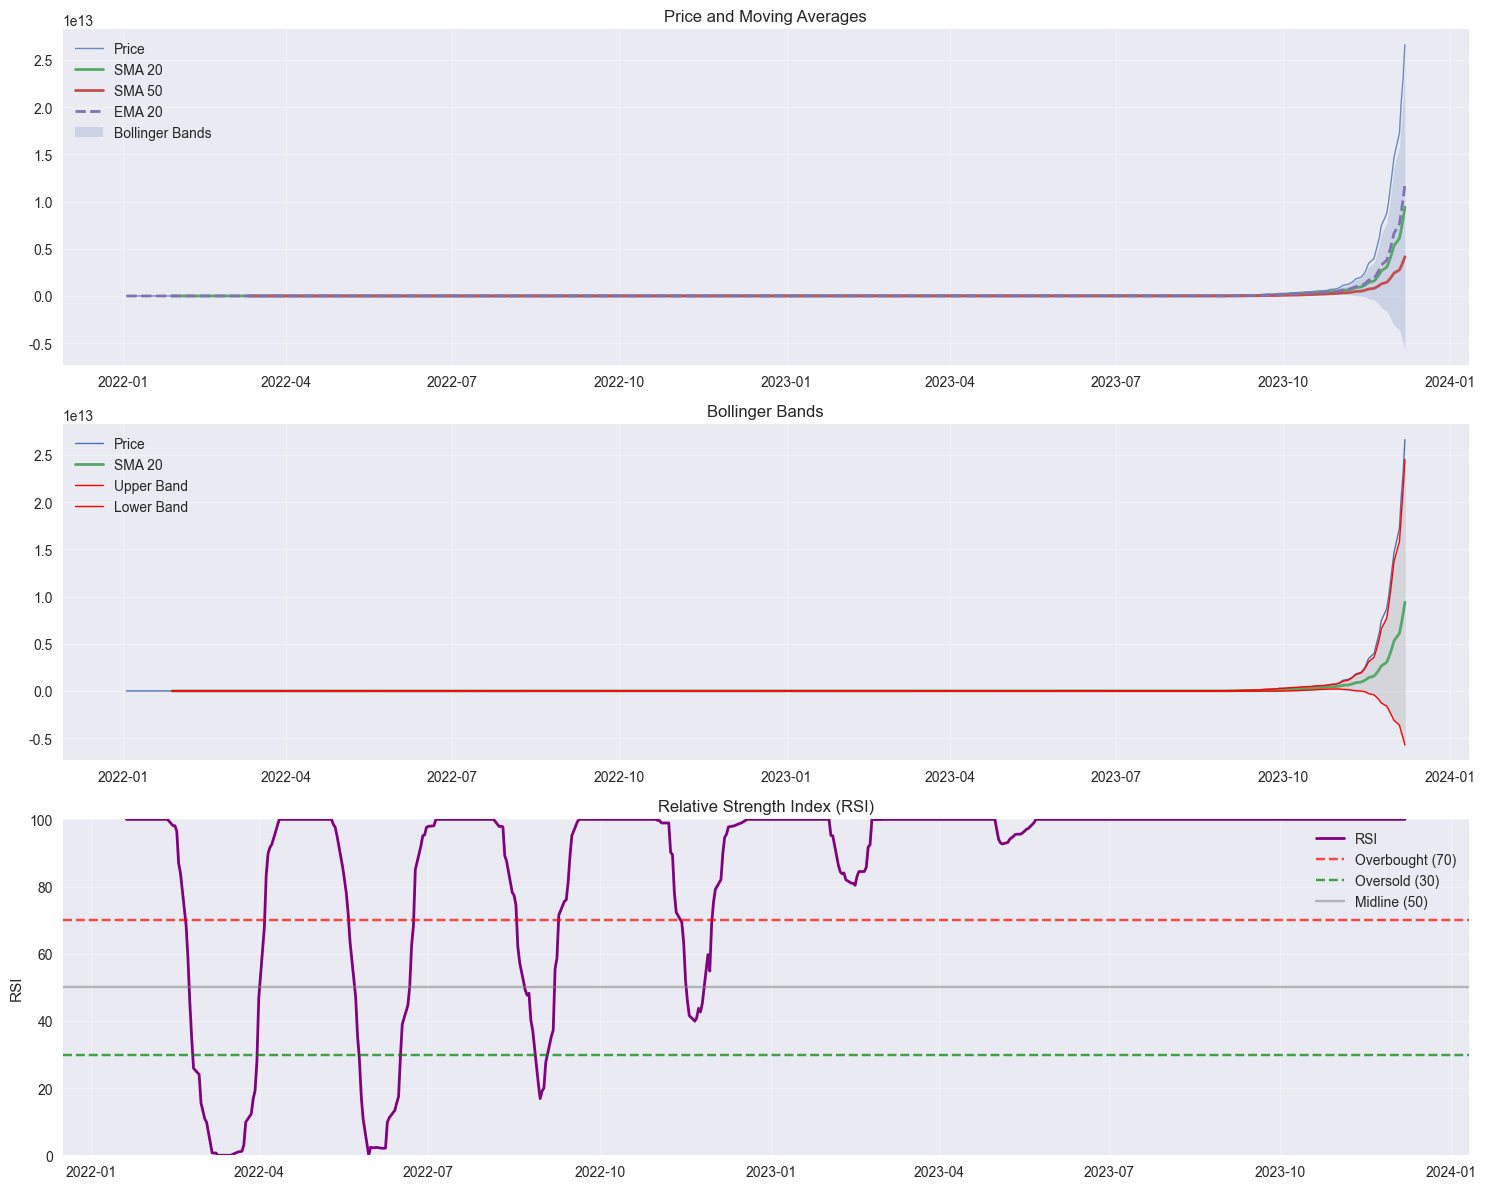

Technical indicators calculated successfully!
Current RSI: 100.00
Current price relative to Bollinger Bands: 1.14


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

# Technical indicators calculation and filtering
def calculate_technical_indicators(prices):
    """Calculate common technical indicators"""
    results = {}
    
    # 1. Simple Moving Average (SMA)
    results['SMA_20'] = pd.Series(prices).rolling(window=20).mean()
    results['SMA_50'] = pd.Series(prices).rolling(window=50).mean()
    
    # 2. Exponential Moving Average (EMA) - implemented with scipy filter
    alpha_20 = 2 / (20 + 1)
    alpha_50 = 2 / (50 + 1)
    
    b_20 = [alpha_20]
    a_20 = [1, -(1 - alpha_20)]
    results['EMA_20'] = pd.Series(signal.lfilter(b_20, a_20, prices))
    
    b_50 = [alpha_50]
    a_50 = [1, -(1 - alpha_50)]
    results['EMA_50'] = pd.Series(signal.lfilter(b_50, a_50, prices))
    
    # 3. Bollinger Bands
    sma_20 = results['SMA_20']
    std_20 = pd.Series(prices).rolling(window=20).std()
    results['BB_Upper'] = sma_20 + 2 * std_20
    results['BB_Lower'] = sma_20 - 2 * std_20
    
    # 4. RSI (Relative Strength Index)
    returns = pd.Series(prices).diff()
    gains = returns.where(returns > 0, 0)
    losses = -returns.where(returns < 0, 0)
    
    avg_gains = gains.rolling(window=14).mean()
    avg_losses = losses.rolling(window=14).mean()
    
    rs = avg_gains / avg_losses
    results['RSI'] = 100 - (100 / (1 + rs))
    
    return results

# Calculate indicators
indicators = calculate_technical_indicators(prices)

# Visualization of technical indicators
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Price and moving averages
axes[0].plot(dates, prices, label='Price', linewidth=1, alpha=0.8)
axes[0].plot(dates, indicators['SMA_20'], label='SMA 20', linewidth=2)
axes[0].plot(dates, indicators['SMA_50'], label='SMA 50', linewidth=2)
axes[0].plot(dates, indicators['EMA_20'], label='EMA 20', linewidth=2, linestyle='--')
axes[0].fill_between(dates, indicators['BB_Upper'], indicators['BB_Lower'], 
                     alpha=0.2, label='Bollinger Bands')
axes[0].set_title('Price and Moving Averages', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Bollinger Bands detailed view
axes[1].plot(dates, prices, label='Price', linewidth=1)
axes[1].plot(dates, indicators['SMA_20'], label='SMA 20', linewidth=2)
axes[1].plot(dates, indicators['BB_Upper'], label='Upper Band', linewidth=1, color='red')
axes[1].plot(dates, indicators['BB_Lower'], label='Lower Band', linewidth=1, color='red')
axes[1].fill_between(dates, indicators['BB_Upper'], indicators['BB_Lower'], 
                     alpha=0.2, color='gray')
axes[1].set_title('Bollinger Bands', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# RSI Indicator
axes[2].plot(dates, indicators['RSI'], label='RSI', linewidth=2, color='purple')
axes[2].axhline(y=70, color='red', linestyle='--', alpha=0.7, label='Overbought (70)')
axes[2].axhline(y=30, color='green', linestyle='--', alpha=0.7, label='Oversold (30)')
axes[2].axhline(y=50, color='gray', linestyle='-', alpha=0.5, label='Midline (50)')
axes[2].set_title('Relative Strength Index (RSI)', fontsize=12)
axes[2].set_ylabel('RSI')
axes[2].set_ylim(0, 100)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Technical indicators calculated successfully!")
print(f"Current RSI: {indicators['RSI'].iloc[-1]:.2f}")
print(f"Current price relative to Bollinger Bands: "
      f"{((prices[-1] - indicators['SMA_20'].iloc[-1]) / (indicators['BB_Upper'].iloc[-1] - indicators['BB_Lower'].iloc[-1]) * 2):.2f}")


# 5. 数值积分 (scipy.integrate)

## 5.1 期权定价中的应用

数值积分在金融中主要用于：
- **期权定价**: 计算期权的理论价值
- **风险度量**: VaR和CVaR的计算
- **概率计算**: 各种金融分布的概率积分


=== 欧式看涨期权定价比较 ===
股价: $100
执行价: $105
到期时间: 3.0个月
无风险利率: 5.0%
波动率: 20.0%

数值积分结果: $0.0000
解析解结果: $2.4779
误差: $2.477902
积分误差估计: 0.00e+00


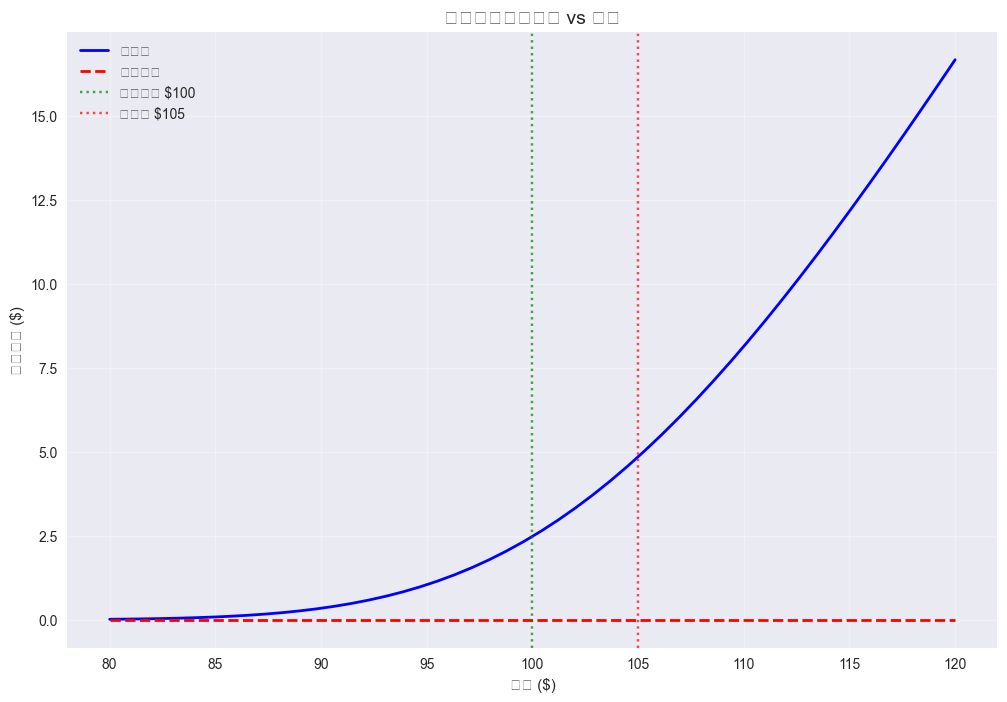

In [30]:
# 欧式期权定价 - Black-Scholes公式的数值实现
def black_scholes_call_numerical(S, K, T, r, sigma):
    """
    使用数值积分计算欧式看涨期权价格
    
    Parameters:
    S: 当前股价
    K: 执行价格
    T: 到期时间（年）
    r: 无风险利率
    sigma: 波动率
    """
    
    def integrand(ST):
        """积分被积函数"""
        # 期权到期时的收益
        payoff = np.maximum(ST - K, 0)
        
        # 对数正态分布的概率密度函数
        d1 = (np.log(ST/S) - (r - 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
        pdf = np.exp(-0.5*d1**2) / (ST * sigma * np.sqrt(2*np.pi*T))
        
        return payoff * pdf
    
    # 数值积分计算期权价格
    result, error = integrate.quad(integrand, 0, np.inf)
    option_price = np.exp(-r*T) * result
    
    return option_price, error

# 解析解 Black-Scholes公式（用于对比）
def black_scholes_call_analytical(S, K, T, r, sigma):
    """Black-Scholes解析解"""
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    call_price = S * stats.norm.cdf(d1) - K * np.exp(-r*T) * stats.norm.cdf(d2)
    return call_price

# 期权参数
S0 = 100    # 当前股价
K = 105     # 执行价格
T = 0.25    # 3个月到期
r = 0.05    # 5%无风险利率
sigma = 0.2 # 20%波动率

# 计算期权价格
numerical_price, integration_error = black_scholes_call_numerical(S0, K, T, r, sigma)
analytical_price = black_scholes_call_analytical(S0, K, T, r, sigma)

print("=== 欧式看涨期权定价比较 ===")
print(f"股价: ${S0}")
print(f"执行价: ${K}")
print(f"到期时间: {T*12:.1f}个月")
print(f"无风险利率: {r*100:.1f}%")
print(f"波动率: {sigma*100:.1f}%")
print()
print(f"数值积分结果: ${numerical_price:.4f}")
print(f"解析解结果: ${analytical_price:.4f}")
print(f"误差: ${abs(numerical_price - analytical_price):.6f}")
print(f"积分误差估计: {integration_error:.2e}")

# 期权价格对参数的敏感性分析
stock_prices = np.linspace(80, 120, 50)
option_prices_numerical = []
option_prices_analytical = []

for S in stock_prices:
    num_price, _ = black_scholes_call_numerical(S, K, T, r, sigma)
    ana_price = black_scholes_call_analytical(S, K, T, r, sigma)
    option_prices_numerical.append(num_price)
    option_prices_analytical.append(ana_price)

# 可视化
plt.figure(figsize=(12, 8))
plt.plot(stock_prices, option_prices_analytical, 'b-', linewidth=2, label='解析解')
plt.plot(stock_prices, option_prices_numerical, 'r--', linewidth=2, label='数值积分')
plt.axvline(x=S0, color='green', linestyle=':', alpha=0.7, label=f'当前股价 ${S0}')
plt.axvline(x=K, color='red', linestyle=':', alpha=0.7, label=f'执行价 ${K}')

plt.xlabel('股价 ($)')
plt.ylabel('期权价格 ($)')
plt.title('欧式看涨期权价格 vs 股价', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# 6. 线性代数 (scipy.linalg)

## 6.1 协方差矩阵分析与主成分分析

线性代数在量化金融中的应用：
- **协方差矩阵**: 资产间相关性分析
- **主成分分析 (PCA)**: 降维和风险因子提取
- **矩阵分解**: 风险模型构建
- **特征值分析**: 投资组合稳定性评估


Extended asset returns data generated
Number of assets: 10
Time series length: 1000

Return statistics summary:
         Stock 1    Stock 2    Stock 3    Stock 4    Stock 5    Stock 6  \
count  1000.0000  1000.0000  1000.0000  1000.0000  1000.0000  1000.0000   
mean     -0.0014    -0.0013    -0.0017    -0.0013    -0.0012    -0.0011   
std       0.0296     0.0226     0.0260     0.0293     0.0249     0.0233   
min      -0.1067    -0.0777    -0.0870    -0.1051    -0.0969    -0.0815   
25%      -0.0205    -0.0159    -0.0195    -0.0224    -0.0180    -0.0168   
50%      -0.0012    -0.0010    -0.0016    -0.0012    -0.0015    -0.0008   
75%       0.0183     0.0140     0.0158     0.0195     0.0154     0.0146   
max       0.0820     0.0625     0.0868     0.0927     0.0694     0.0673   

         Stock 7    Stock 8    Stock 9   Stock 10  
count  1000.0000  1000.0000  1000.0000  1000.0000  
mean     -0.0019    -0.0016    -0.0015    -0.0017  
std       0.0259     0.0218     0.0249     0.0232  
min 

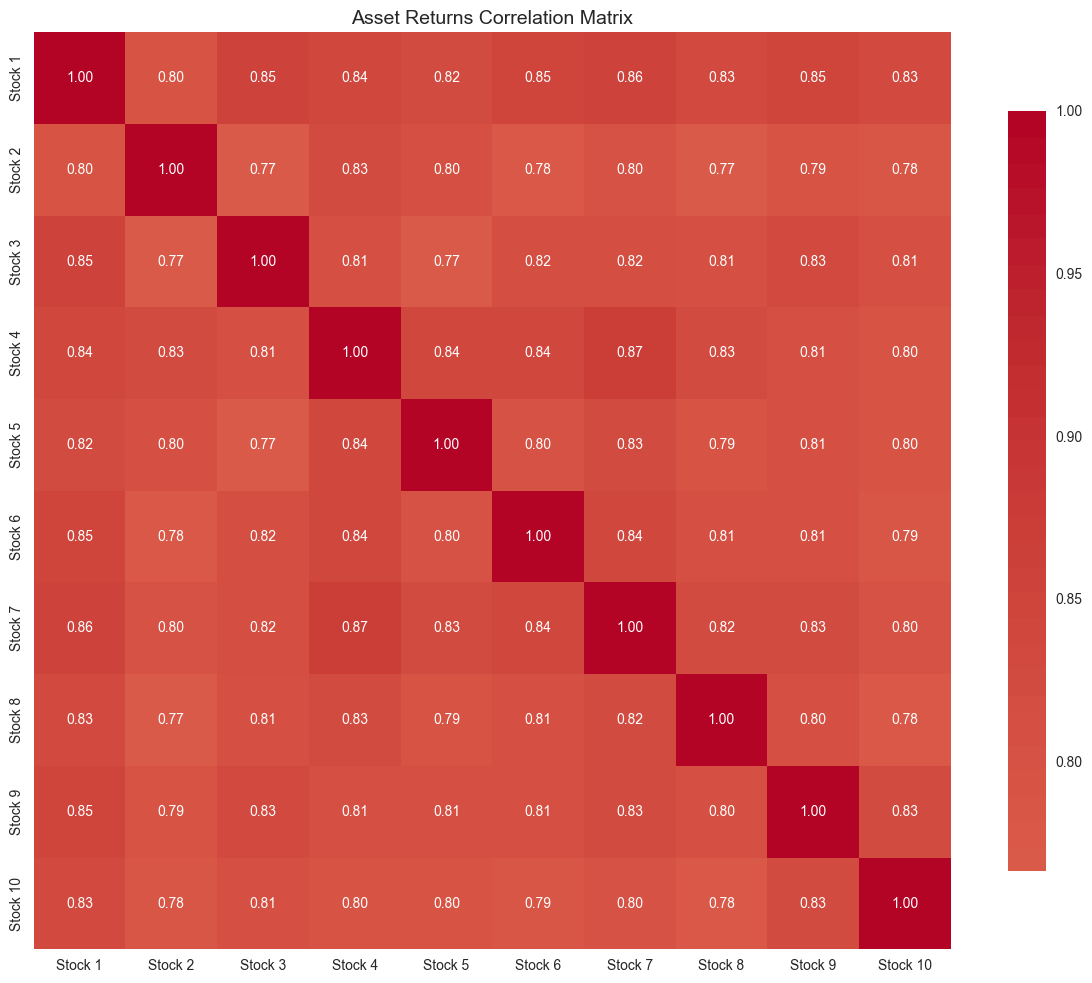

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Generate extended asset returns data for PCA analysis
np.random.seed(42)

# Generate return data for 10 stocks
n_assets = 10
n_days = 1000

# Create factor model: 3 common factors
factor_loadings = np.random.uniform(0.3, 0.8, (n_assets, 3))
factor_returns = np.random.multivariate_normal([0, 0, 0], 
                                               [[0.0004, 0.0001, 0.0002],
                                                [0.0001, 0.0003, 0.0001], 
                                                [0.0002, 0.0001, 0.0005]], n_days)

# Idiosyncratic risk
idiosyncratic_risk = np.random.normal(0, 0.01, (n_days, n_assets))

# Generate stock returns
stock_returns = np.dot(factor_returns, factor_loadings.T) + idiosyncratic_risk

# Create DataFrame
asset_names = [f'Stock {i+1}' for i in range(n_assets)]
returns_df = pd.DataFrame(stock_returns, columns=asset_names)

print("Extended asset returns data generated")
print(f"Number of assets: {n_assets}")
print(f"Time series length: {n_days}")
print("\nReturn statistics summary:")
print(returns_df.describe().round(4))

# Calculate covariance and correlation matrices
cov_matrix = returns_df.cov()
corr_matrix = returns_df.corr()

print(f"\nCovariance matrix shape: {cov_matrix.shape}")
print(f"Condition number of correlation matrix: {np.linalg.cond(corr_matrix):.2f}")

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Asset Returns Correlation Matrix', fontsize=14)
plt.tight_layout()
plt.show()


=== PCA Results ===
Eigenvalues: [8.326  0.2859 0.2545 0.2015 0.1958 0.1694 0.1599 0.1545 0.1318 0.1207]
Explained Variance Ratio: [0.8326 0.0286 0.0255 0.0201 0.0196 0.0169 0.016  0.0154 0.0132 0.0121]
Cumulative Variance Ratio: [0.8326 0.8612 0.8866 0.9068 0.9264 0.9433 0.9593 0.9747 0.9879 1.    ]


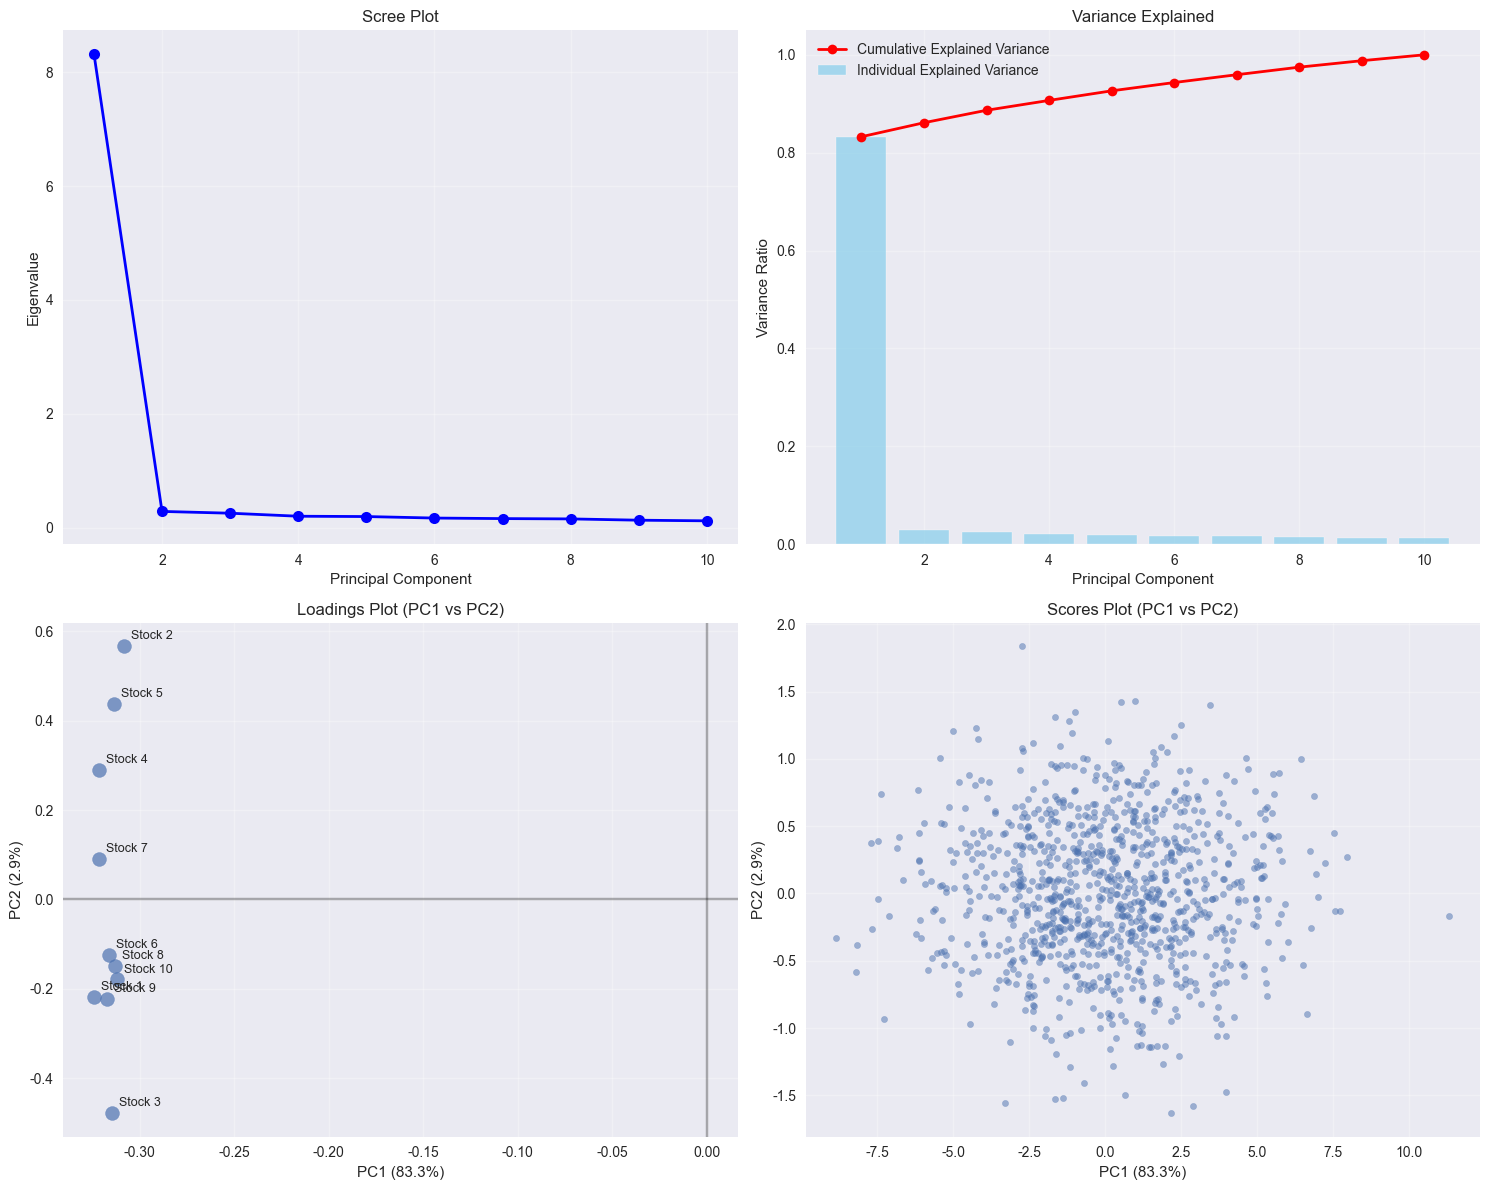


=== PCA Insights ===
Number of PCs needed to explain 90% variance: 4
Number of PCs needed to explain 95% variance: 7
Variance explained by first 3 PCs: 88.66%

=== Principal Component Interpretation ===

Principal Component 1 (Explained Variance: 83.26%):
  Stock 1: -0.324
  Stock 7: -0.322
  Stock 4: -0.321

Principal Component 2 (Explained Variance: 2.86%):
  Stock 2: 0.567
  Stock 3: -0.479
  Stock 5: 0.436

Principal Component 3 (Explained Variance: 2.55%):
  Stock 10: 0.621
  Stock 8: -0.390
  Stock 6: -0.381

=== Risk Decomposition ===
Total Risk: 0.006388
Systematic Risk (first 3 PCs): 8.866464 (138795.1%)
Idiosyncratic Risk: -8.860076 (-138695.1%)


In [34]:
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt

# Principal Component Analysis (PCA)
def perform_pca_analysis(returns_data):
    """
    Perform PCA on return data
    """
    # Standardize the data
    standardized_returns = (returns_data - returns_data.mean()) / returns_data.std()
    
    # Covariance matrix
    cov_matrix = np.cov(standardized_returns.T)
    
    # Eigen decomposition
    eigenvalues, eigenvectors = linalg.eigh(cov_matrix)
    
    # Sort by descending eigenvalue
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Variance explained ratio
    explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    
    # Principal component scores
    principal_components = np.dot(standardized_returns, eigenvectors)
    
    return {
        'eigenvalues': eigenvalues,
        'eigenvectors': eigenvectors,
        'explained_variance_ratio': explained_variance_ratio,
        'cumulative_variance_ratio': cumulative_variance_ratio,
        'principal_components': principal_components,
        'standardized_returns': standardized_returns
    }

# Run PCA
pca_results = perform_pca_analysis(returns_df)

# Output PCA results
print("=== PCA Results ===")
print(f"Eigenvalues: {pca_results['eigenvalues'].round(4)}")
print(f"Explained Variance Ratio: {pca_results['explained_variance_ratio'].round(4)}")
print(f"Cumulative Variance Ratio: {pca_results['cumulative_variance_ratio'].round(4)}")

# Visualize PCA results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Scree plot
axes[0, 0].plot(range(1, len(pca_results['eigenvalues'])+1), 
                pca_results['eigenvalues'], 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_title('Scree Plot', fontsize=12)
axes[0, 0].set_xlabel('Principal Component')
axes[0, 0].set_ylabel('Eigenvalue')
axes[0, 0].grid(True, alpha=0.3)

# 2. Variance explained
axes[0, 1].bar(range(1, len(pca_results['explained_variance_ratio'])+1), 
               pca_results['explained_variance_ratio'], alpha=0.7, color='skyblue')
axes[0, 1].plot(range(1, len(pca_results['cumulative_variance_ratio'])+1), 
                pca_results['cumulative_variance_ratio'], 'ro-', linewidth=2)
axes[0, 1].set_title('Variance Explained', fontsize=12)
axes[0, 1].set_xlabel('Principal Component')
axes[0, 1].set_ylabel('Variance Ratio')
axes[0, 1].legend(['Cumulative Explained Variance', 'Individual Explained Variance'])
axes[0, 1].grid(True, alpha=0.3)

# 3. Loadings plot for first two PCs
pc1_loadings = pca_results['eigenvectors'][:, 0]
pc2_loadings = pca_results['eigenvectors'][:, 1]

axes[1, 0].scatter(pc1_loadings, pc2_loadings, s=100, alpha=0.7)
for i, asset in enumerate(asset_names):
    axes[1, 0].annotate(asset, (pc1_loadings[i], pc2_loadings[i]), 
                       xytext=(5, 5), textcoords='offset points', fontsize=9)

axes[1, 0].set_title('Loadings Plot (PC1 vs PC2)', fontsize=12)
axes[1, 0].set_xlabel(f'PC1 ({pca_results["explained_variance_ratio"][0]*100:.1f}%)')
axes[1, 0].set_ylabel(f'PC2 ({pca_results["explained_variance_ratio"][1]*100:.1f}%)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(y=0, color='k', linestyle='-', alpha=0.3)
axes[1, 0].axvline(x=0, color='k', linestyle='-', alpha=0.3)

# 4. Scores scatter plot for first two PCs
pc_scores = pca_results['principal_components']
axes[1, 1].scatter(pc_scores[:, 0], pc_scores[:, 1], alpha=0.5, s=20)
axes[1, 1].set_title('Scores Plot (PC1 vs PC2)', fontsize=12)
axes[1, 1].set_xlabel(f'PC1 ({pca_results["explained_variance_ratio"][0]*100:.1f}%)')
axes[1, 1].set_ylabel(f'PC2 ({pca_results["explained_variance_ratio"][1]*100:.1f}%)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analysis of key findings
n_components_90 = np.argmax(pca_results['cumulative_variance_ratio'] >= 0.9) + 1
n_components_95 = np.argmax(pca_results['cumulative_variance_ratio'] >= 0.95) + 1

print("\n=== PCA Insights ===")
print(f"Number of PCs needed to explain 90% variance: {n_components_90}")
print(f"Number of PCs needed to explain 95% variance: {n_components_95}")
print(f"Variance explained by first 3 PCs: {pca_results['cumulative_variance_ratio'][2]*100:.2f}%")

# Principal component interpretation
print("\n=== Principal Component Interpretation ===")
for i in range(min(3, len(pca_results['eigenvalues']))):
    print(f"\nPrincipal Component {i+1} (Explained Variance: {pca_results['explained_variance_ratio'][i]*100:.2f}%):")
    loadings = pca_results['eigenvectors'][:, i]
    top_assets = np.argsort(np.abs(loadings))[-3:][::-1]
    for j in top_assets:
        print(f"  {asset_names[j]}: {loadings[j]:.3f}")

# Risk decomposition
total_risk = np.trace(cov_matrix)
systematic_risk = np.sum(pca_results['eigenvalues'][:3])  # first 3 PCs
idiosyncratic_risk = total_risk - systematic_risk

print("\n=== Risk Decomposition ===")
print(f"Total Risk: {total_risk:.6f}")
print(f"Systematic Risk (first 3 PCs): {systematic_risk:.6f} ({systematic_risk/total_risk*100:.1f}%)")
print(f"Idiosyncratic Risk: {idiosyncratic_risk:.6f} ({idiosyncratic_risk/total_risk*100:.1f}%)")


# 总结与实际应用

## SciPy在量化金融中的核心价值

通过本notebook的学习，我们全面了解了SciPy在金融数据分析和量化投资中的重要应用：

### 1. 统计分析 (scipy.stats)
- **应用场景**: 风险管理、回测分析、策略评估
- **核心功能**: 分布拟合、假设检验、风险度量
- **实际价值**: 帮助量化分析师理解收益率分布特征，进行科学的风险评估

### 3. 插值与拟合 (scipy.interpolate)
- **应用场景**: 利率曲线构建、缺失数据处理、价格预测
- **核心功能**: 样条插值、多项式拟合、数据平滑
- **实际价值**: 从离散市场数据构建连续的金融曲线，提高数据质量

### 4. 信号处理 (scipy.signal)
- **应用场景**: 技术分析、趋势识别、噪声过滤
- **核心功能**: 数字滤波、频谱分析、信号变换
- **实际价值**: 开发技术指标，识别市场信号，构建交易策略

### 5. 数值积分 (scipy.integrate)
- **应用场景**: 衍生品定价、风险度量、概率计算
- **核心功能**: 数值积分、微分方程求解
- **实际价值**: 实现复杂金融模型的数值计算，如期权定价

### 6. 线性代数 (scipy.linalg)
- **应用场景**: 风险模型、因子分析、降维处理
- **核心功能**: 矩阵分解、特征值分析、主成分分析
- **实际价值**: 构建多因子模型，进行风险归因和组合分析

## 最佳实践建议

1. **数据预处理**: 始终检查数据质量，处理异常值和缺失值
2. **模型验证**: 使用多种方法验证结果的稳健性
3. **风险控制**: 在优化过程中加入适当的约束条件
4. **参数敏感性**: 分析模型对参数变化的敏感性
5. **实时更新**: 定期更新模型参数，适应市场变化

## 进阶学习方向

- **机器学习**: 结合scikit-learn进行预测建模
- **深度学习**: 使用TensorFlow/PyTorch构建神经网络模型
- **高频交易**: 学习更高级的信号处理和实时计算技术
- **风险管理**: 深入学习VaR、CVaR等风险度量方法
- **衍生品定价**: 掌握更复杂的期权定价模型

SciPy为量化金融提供了强大的数学工具基础，是每个量化分析师必须掌握的核心技能！
